# The SAT in NYC: Analyzing High School Achievement

Racial bias in the SAT is a topic that has been thoroughly researched and discussed. Thanks to the wealth of resources at the [NYC Open Data Platform](http://opendata.cityofnewyork.us/), I can continue to beat the horse from the comfort of my own home! 

While it has been shown that race and ethnicity [continue to be an important factor](https://www.insidehighered.com/news/2015/10/27/study-finds-race-growing-explanatory-factor-sat-scores-california) in predicting SAT performance, it's worth diving into the data to see what insights we can generate for ourselves. We'll be using [7 data sets](https://data.cityofnewyork.us/browse?tags=doe) collected from the NYC Department of Education listings at Open Data. They are:
* [2010 AP Scores](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e)
* [Class Size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j)
* [Graduation Outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a)
* [NYC High School Directory](https://data.cityofnewyork.us/Education/DOE-High-School-Directory-2014-2015/n3p6-zve2)
* [2012 SAT Results](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4)
* [2011 NYC School Survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8)

First we'll read all of the data into Pandas dataframes and perform some quick cleanup. The NYC Survey has a ridiculous amount of detail (over 1700 columns worth in both files), so we'll create a list of the columns relevant to our analysis and keep those in our final dataframe. To ensure consistency, we copy the lowercase 'dbn' (District Borough Number, used to identify individual schools) column to a 'DBN' column.

# Reading and wrangling the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

There are a couple more inconsistencies in how the various datasets categorize each school. The high school directory's column title needs to be capitalized, which is easy enough. 

In the case of our data set for class size, the DBN isn't provided for us. Instead we have the CSD (Citywide School District) and school code. As it turns out, the DBN is a combination of these two values. We write a quick function to properly pad CSD values, and then add the school code values to the end of each CSD in order to create a DBN column. 

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Numeric conversions and parsing coordinates

Some of the columns we'll want to perform analysis on aren't of the proper data type. We convert the values for SAT scores and the number of test takers to numeric types in addition to creating a column that takes the sum of all three score values. We do the same for AP tests, converting the data for the number of test takers, the number of exams taken, and the number of exams that might qualify for college credit.

We will also want to do some mapping later, so we use a regex search to strip the values for latitude and longitude from the location column in the high school directory and assign them to individual columns. 

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score', 'Num of SAT Test Takers']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

In [5]:
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Too much data

Now we condense our data sets. The class size data has values for K-8 in addition to high school. We only want the high school data. It also has various types of programs in each school, so we pull only the general education program data. This still leaves us with some schools containing multiple rows, so we group the set by DBN and take the average values to handle any schools with multiple columns. 

Our demographics data contains information for multiple years, so we take only the data that corresponds to the year for our SAT results, 2012. 

The most recent data available for graduation outcomes is from 2006. We take only the 2006 graduation data. There are also a few rows that are specific to gender, so we take only the data that includes the total cohort. 

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Mergers, Not Acquisitions

With everything organized and consistent, we're ready to combine our individual data sets into one dataframe. We use a left outer join when merging the AP and graduation datasets as they have a number of absent DBN values and we don't lose information concerning the SAT results, the core information for our analysis. With the rest of the data most DBN values are present, so we use an inner join to prevent too many null values cropping up.

We then attempt to replace any null values with the column mean, and for those columns that don't have a mean we replace null values with 0.

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

We'll be doing analysis based on school district, so we pull the district values back out from the DBN and assign them to their own column.

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Correlations

Ultimately, our analysis is all about finding correlations between SAT results and various factors that can describe a school. Let's calculate the correlations for the data frame and look at the values for total SAT score.

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

Num of SAT Test Takers                  0.485338
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num             

The values towards the end (N_s, N_t, saf_p_11, etc.) correspond to responses to the NYC School Survey. The survey takes responses from teachers, students, and parents on a variety of topics that influence educational environments. Some of the values are on a scale from 1 to 10, with the score assigned based on average responses to each question. The possible responses are "Strongly disagree", "Disagree", "Agree", and "Strongly Agree". For each value in our dataset:
* s => student
* p => parent
* t => teacher

The categories we've kept are:
* rr => Response rate
* N => Number of respondents
* saf => Safety score
* eng => Engagement score
* aca => Academic expectations score
* com => Communication score

Now that we've wrangled the data beast, we can get into the real fun.

## I'd graph that.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

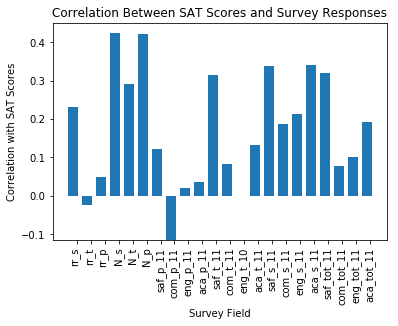

In [12]:
fields=survey_fields[1:]
bar_heights = correlations.ix[fields]
bar_positions = np.arange(len(fields)) + 0.75
tick_positions = range(1,len(fields)+1)

fig, ax = plt.subplots()

ax.bar(bar_positions, bar_heights, .75)
ax.set_xticks(tick_positions)
ax.set_xticklabels(fields, rotation=90)
plt.xlabel('Survey Field')
plt.ylabel('Correlation with SAT Scores')
plt.title('Correlation Between SAT Scores and Survey Responses')
plt.show()

## A rudimentary analysis
We see the values with the strongest correlation are N_s and N_p. This seems to indicate schools with more students tend to have higher SAT scores. 

We also note a significant positive correlation with safety, where students', teachers' and parents' sense of safety carry roughly the same r-value. Student academic expectations also demonstrate a significant correlation, though parental expectations show no correlation. This would imply that students' expectations of themselves are a stronger indicator of performance on the SAT, regardless of what a parent thinks. 

Strangely, the student response rate shows a much stronger correlation to SAT performance compared to teachers and parents. This may be a result of a higher concentration of motivated students, who are also more likely to take the time to fill out a survey. We also saw that schools with more foreign-born students are less likely to do well on the SAT. Perhaps these schools also have lower response rates, as the students may struggle with comprehension on a survey as well.

The most surprising result is that communication scores from students show a slight positive correlation (nearly .2) , while communication scores from parents show a slight negative correlation (just below -.1). While both values only show a slight correlation, the difference between them seems to demonstrate a stark contrast in sense of educational communication between students and their parents when looking at SAT performance. 

## Safety first

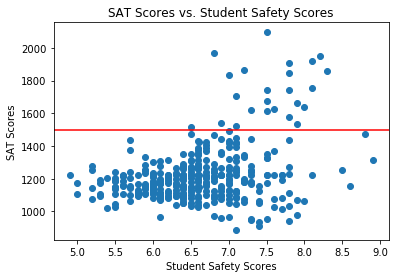

In [13]:
x_ax = combined.saf_s_11
y_ax = combined.sat_score

fig, ax = plt.subplots()
ax.scatter(x_ax,y_ax)
ax.set_xlabel('Student Safety Scores')
ax.set_ylabel('SAT Scores')
ax.set_title('SAT Scores vs. Student Safety Scores')
ax.axhline(y=1500, color='red')
plt.show()

There appear to be two trends in the plot. We see that a relatively small number of schools with very high SAT Scores are influencing our correlation value. More schools with high safety scores demonstrate average performance. It's interesting to note that the schools with the lowest SAT scores (below 1000) tend to have relatively high safety scores as well. Those on the lower end in terms of sense of student safety seem to fall within the average range of NYC SAT scores, looking at the large cluster scoring between 1000 and 1300. When this data was released the [average SAT score was 1500](http://blog.prepscholar.com/what-is-a-good-sat-score-a-bad-sat-score-an-excellent-sat-score), indicated by the horizontal line (total points have been reduced and the new national average is 1000). This invites further discussion about the efficacy of NYC's school system compared to the rest of the U.S., but we'll leave that for another time. At the very least, it seems that while safety is a factor in predicting SAT performance to an extent, above a certain threshold there's generally no relationship between sense of safety among students and test performance.

In order to explore this further, let's take a geographic view of the data. I've written a function to plot numerous maps of different categories on a square grid in order to ease visual analysis of district-by-district data.

In [14]:
districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,87.166667,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,120.890672,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,132.781343,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,102.571429,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,93.160768,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


In [15]:
from mpl_toolkits.basemap import Basemap

In [40]:
def quick_map(cats=[], df=districts):
    '''
    Plots a square grid of Basemap projections with dimensions determined by 
    the number of categories passed in. When the number of categories to plot
    has been exceeded in the total count of plots, we break the process and 
    display our plots.
    
    Could take a second argument pointing to the latitude and longitude values
    of a different dataframe in order to make a more generalized function,
    but this suits my purposes here.

    '''
    fig = plt.figure(figsize=(10,10))
    
    longitudes = df.lon.tolist()
    latitudes = df.lat.tolist()
    
    floor = int(np.sqrt(len(cats)))    
    if floor ** 2 ==len(cats):
        sq_chk = floor
    else:
        sq_chk = floor + 1
        
    cat_count = 0
    for i in range(sq_chk):
        for j in range(sq_chk):
            try:
                break_test = cats[cat_count]
            except:
                break
                
            ax = fig.add_subplot(sq_chk,sq_chk,cat_count + 1)
            ax.set_title(cats[cat_count])
            m = Basemap(
                projection='merc', 
                llcrnrlat=40.496044, 
                urcrnrlat=40.915256, 
                llcrnrlon=-74.255735, 
                urcrnrlon=-73.700272,
                resolution='i'
            )

            m.fillcontinents(color='coral')
            m.drawmapboundary(fill_color='#85A6D9')
            m.drawcoastlines(color='#6D5F47', linewidth=.4)
            m.drawrivers(color='#6D5F47', linewidth=.4)

            m.scatter(x=longitudes, y=latitudes, s=35, zorder=2, latlon=True, c=df[cats[cat_count]], cmap="winter")
            cat_count += 1
                
    plt.show()

## Mercy Mercy Me (The Geography)

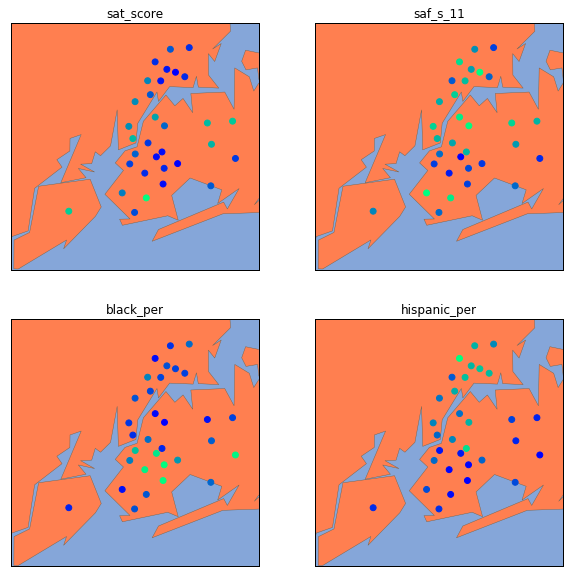

In [17]:
categories = ['sat_score', 'saf_s_11', 'black_per', 'hispanic_per']
quick_map(categories)

Brooklyn school districts, the collection of dark blue points in the middle of the map, show almost uniformly low safety scores relative to the average response, with two notable exceptions in South Brooklyn. Northwest Queens districts scores highly for safety, though as a whole New York's largest borough by landmass varies greatly in safety ratings. Manhattan tends to show an above average safety score. We note strong variability despite high concentration in the Bronx. 

### Taking a closer look

Looking at the maps showing percentage of black and hispanic students, we see schools with majority hispanic students tend be in the Bronx, those with majority black students tend to be in Brooklyn, and most notably the mapping percentage of black students by district looks to be an inverse of that showing safety scores. There appears to be a very strong correlation between the percentage of black students at a school and how safe students at the school feel. Let's dig in to this.

Correlation between % of black students and student safety score, by district:  -0.814141295664
Correlation between % of black students and parent safety score, by district:  -0.450720788785
Correlation between % of black students and teacher safety score, by district:  -0.519795974555


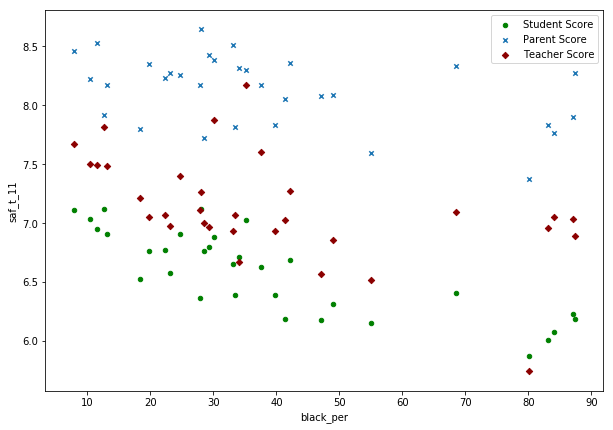

In [18]:
dist_corr = districts.corr()
print('Correlation between % of black students and student safety score, by district: ', dist_corr['black_per']['saf_s_11'])
print('Correlation between % of black students and parent safety score, by district: ', dist_corr['black_per']['saf_p_11'])
print('Correlation between % of black students and teacher safety score, by district: ', dist_corr['black_per']['saf_t_11'])

ax = districts.plot.scatter(x='black_per', y='saf_s_11', color='g', marker='o', label='Student Score', figsize=(10,7))
districts.plot.scatter(x='black_per', y='saf_p_11', marker='x', label='Parent Score', ax=ax)
districts.plot.scatter(x='black_per', y='saf_t_11', color='DarkRed', marker='D', label='Teacher Score', ax = ax)

The first thing to note is the difference in average safety score between students, parents, and teachers. We see three distinct bands, where nearly every district has average scores below 7 for students and above 7.5 for parents. We also see that the negative correlation between percentage of black students and safety scores is much stronger for students, though a lesser trend is still notable with parents and teachers. Amongst students, those districts with the highest percentage of black students also tend carry the lowest safety values. This is not true for teachers. With teacher scores, four of the five lowest values are in districts with an average share of black students between 30% and 55%. For parents, only two districts have scores below 7.6, one with 80% black students and the other roughly 55%. For parent responses, districts with a greater share of black students still tend to fall on the lower end of safety ratings, but they don't stand out as much as with student scores. 

### How are these black-concentrated schools performing?

In [72]:
hi_black_per = combined[combined.black_per >= 85.]
print(hi_black_per.sat_score.describe())
print(hi_black_per.DBN)

count      24.000000
mean     1163.851617
std       104.631329
min       963.000000
25%      1095.750000
50%      1152.000000
75%      1183.500000
max      1436.000000
Name: sat_score, dtype: float64
192    13K595
194    13K670
220    16K455
223    17K382
226    17K528
227    17K531
228    17K533
229    17K537
230    17K539
235    17K590
236    17K600
237    18K563
238    18K566
240    18K569
241    18K576
242    18K589
243    18K617
244    18K629
245    18K633
280    23K493
281    23K514
331    29Q259
335    29Q326
337    29Q498
Name: DBN, dtype: object


In [70]:
hi_score = hi_black_per[hi_black_per.sat_score > 1200]
print(hi_score['SCHOOL NAME'])
print(hi_score.DBN)

78     THURGOOD MARSHALL ACADEMY FOR LEARNING AND SOC...
186    SCIENCE SKILLS CENTER HIGH SCHOOL FOR SCIENCE,...
189        THE URBAN ASSEMBLY SCHOOL FOR LAW AND JUSTICE
191    URBAN ASSEMBLY INSTITUTE OF MATH AND SCIENCE F...
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
217                     BROOKLYN HIGH SCHOOL OF THE ARTS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
232    HIGH SCHOOL FOR PUBLIC SERVICE: HEROES OF TOMO...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
279                             BROOKLYN COLLEGE ACADEMY
332                    EXCELSIOR PREPARATORY HIGH SCHOOL
335                              CAMBRIA HEIGHTS ACADEMY
336    MATHEMATICS, SCIENCE RESEARCH AND TECHNOLOGY M...
Name: SCHOOL NAME, dtype: object
78     05M670
186    13K419
189    13K483
191    13K527
192    13K595
194    13K670
217    15K656
231    17K543


In [19]:
print(combined.black_per.mean())
print(combined.white_per.mean())
print(combined.asian_per.mean())
print(combined.hispanic_per.mean())


36.57520661157022
8.430027548209367
10.149586776859508
44.06831955922865


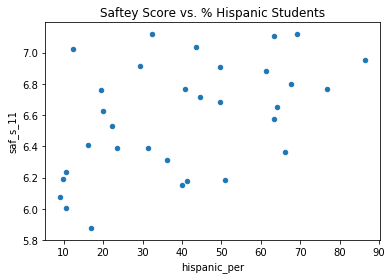

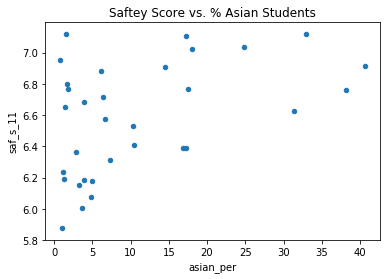

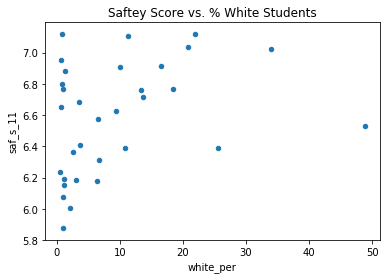

In [20]:
districts.plot(x='hispanic_per', y='saf_s_11', kind='scatter', title='Saftey Score vs. % Hispanic Students')
districts.plot(x='asian_per', y='saf_s_11', kind='scatter', title='Saftey Score vs. % Asian Students')
districts.plot(x='white_per', y='saf_s_11', kind='scatter', title='Saftey Score vs. % White Students')

In [52]:
print(combined[combined.asian_per > 50.][combined.sat_score < 1500]['SCHOOL NAME'])
print(combined[combined.asian_per > 50.]['SCHOOL NAME'])
combined.iloc[297]

46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
297                   FLUSHING INTERNATIONAL HIGH SCHOOL
298            EASTsWEST SCHOOL OF INTERNATIONAL STUDIES
305                            FRANCIS LEWIS HIGH SCHOOL
324    THOMAS A. EDISON CAREER AND TECHNICAL EDUCATIO...
Name: SCHOOL NAME, dtype: object
23                     BARUCH COLLEGE CAMPUS HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
297                   FLUSHING INTERNATIONAL HIGH SCHOOL
298            EASTsWEST SCHOOL OF INTERNATIONAL STUDIES
302                          TOWNSEND HARRIS HIGH SCHOOL
305                            FRANCIS LEWIS HIGH SCHOOL
324    THOMAS A. EDISON CAREER AND TECHNICAL EDUCATIO...
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
Name: SCHOOL NAME, dtype: object


c:\users\wolfa\anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


DBN                                                                                25Q263
SCHOOL NAME                                            FLUSHING INTERNATIONAL HIGH SCHOOL
Num of SAT Test Takers                                                                 45
SAT Critical Reading Avg. Score                                                       314
SAT Math Avg. Score                                                                   417
SAT Writing Avg. Score                                                                318
sat_score                                                                            1049
SchoolName                                                                              0
AP Test Takers                                                                    129.029
Total Exams Taken                                                                 197.038
Number of Exams with scores 3 4 or 5                                               153.45
Demographi

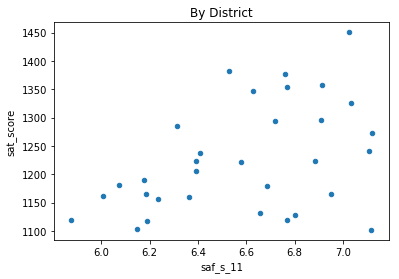

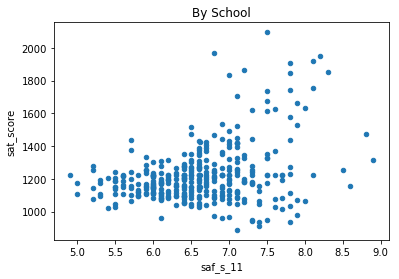

In [22]:
dist_corr = districts.corr()
districts.plot(x='saf_s_11', y='sat_score', kind='scatter', title='By District')
combined.plot(x='saf_s_11', y='sat_score', kind='scatter', title='By School')

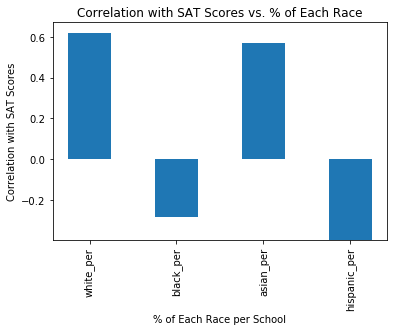

In [54]:
race_per = ['white_per', 'black_per', 'asian_per', 'hispanic_per']

bar_heights = correlations.ix[race_per]
bar_pos = np.arange(4) + 1
tick_pos = range(1, 5)

fig, ax = plt.subplots()

ax.bar(bar_pos, bar_heights, .5)
ax.set_xticks(tick_pos)
ax.set_xticklabels(race_per, rotation=90)
ax.set_xlabel('% of Each Race per School')
ax.set_ylabel('Correlation with SAT Scores')
plt.title('Correlation with SAT Scores vs. % of Each Race')
plt.show()

We find a strong positive correlation between SAT scores and the percentage of asian and white students at a school. The percentage of hispanic students has a notable negative correlation, and the percentage of black students shows a slightly weaker correlation than that of hispanics. While this may initially point to Enlish ability as an indicator of SAT performance, that would neglect the fact that many asian students may be learning English as well. Let's dive into the data and see what we find.

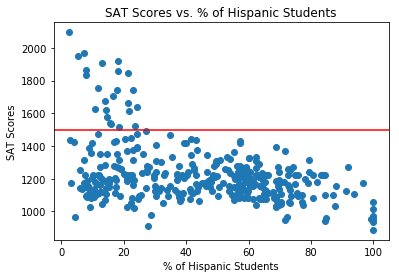

In [24]:
x_ax = combined.hispanic_per
y_ax = combined.sat_score

fig, ax = plt.subplots()
ax.scatter(x=x_ax, y=y_ax)
ax.axhline(y=1500, color='red')
ax.set_xlabel('% of Hispanic Students')
ax.set_ylabel('SAT Scores')
plt.title('SAT Scores vs. % of Hispanic Students')
plt.show()

The schools with the highest SAT scores (and every school above the national avereage) have fewer than 25% hispanic student populations. This is a significant fact, and demonstrates great inequality in the SAT for hispanic students. Those schools with ~100% hispanic populations all had average scores below 1100. We note two strong clusters, one of schools with hispanic percentages between 55% and 70% and another between 5% and 20%. Both of these clusters fall within the same range of scores.

# Schools with > 95% hispanic students

In [25]:
over95 = combined[combined['hispanic_per'] >= 95.]
print(over95['SCHOOL NAME'], '\n', over95['sat_score'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object 
 44     1058.0
82     1174.0
89     1014.0
125     951.0
141     934.0
176     970.0
253     887.0
286     951.0
Name: sat_score, dtype: float64


All of the schools with a percentage of hispanic students above 95% are transition schools for immigrants. Two are in Manhattan, three are in the bronx, one is in Brookly and one is in Queens. Washington Heights School focuses on students from the Dominican Republic and Dominican Americans. Gregorio Luperon was originally a transitional program that later transitioned into a full-fledged 4-year high school. The Academy for Language and Technology only admits spanish speaking students that have been in the U.S. for less than 4 years, the Internation School for Liberal Arts has a mission statement geared towards the strength of bilingual education, and Pan American International is a college preparatory school for Spanish speakers learning English. In total, we find that schools with very high concentrations of hispanic students tend to focus on helping immigrants learn English and succeed in American society. We also find that these schools tend to have very low SAT scores, which makes sense given the language barrier. 

# Schools with < 10% hispanic sudents and average SATs above 1450

In [26]:
under10 = combined[combined['hispanic_per'] < 10]
under10 = under10[under10['sat_score'] > 1450]
print(under10['SCHOOL NAME'],'\n', under10.sat_score)
print(under10['Num of SAT Test Takers'])
print(under10['N_s'])
print('Avg. # of SAT Test Takers, scores over 1500: ', combined[combined.sat_score >= 1500]['Num of SAT Test Takers'].mean())
print('Avg. # of SAT Test Takers, top 5 schools: ', (832+731+1277+121+227)/5)
print('Avg. # of student survey responses, complete set: ', combined['N_s'].mean())

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object 
 37     2096.0
151    1969.0
187    1833.0
327    1868.0
356    1953.0
Name: sat_score, dtype: float64
37      832.0
151     731.0
187    1277.0
327     121.0
356     227.0
Name: Num of SAT Test Takers, dtype: float64
37     3039.0
151    2956.0
187    4768.0
327     399.0
356    1003.0
Name: N_s, dtype: float64
Avg. # of SAT Test Takers, scores over 1500:  289.4166666666667
Avg. # of SAT Test Takers, top 5 schools:  637.6
Avg. # of student survey responses, complete set:  598.2083333333334


In [27]:
combined['Num of SAT Test Takers'].mean()

128.12537313432838

Only 5 schools have a hispanic population under 5% and average SATs above 1450. Unsurprisingly, they're 4 of the 9 "specialized high schools" in NYC. All 4 are publicly funded technical schools, highly focused on Science, Technology, Engineering and Mathematics (STEM) disciplines. These schools account for just over a fifth of the 24 schools with average SAT's above 1500. At a glance we note that these schools also have a much higher number of survey respondents than average. Amongst all schools with average SAT scores above 1500 the top 5 tend to have more students taking tests, and it's worth noting that Queens High School formed in 2002 and Staten Island Technical School formed in 1988. This is likely the primary factor when looking at the difference in number of test takers. The next youngest school is The Bronx High School of Science, which was founded in 1938. Without Queens and Staten Island, the average number of test takers is 309 students higher. 

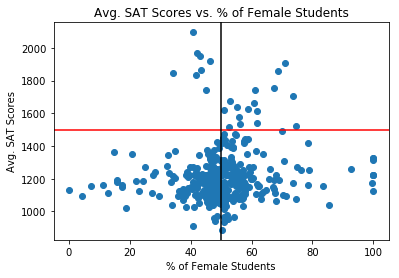

In [28]:
fig, ax1 = plt.subplots()
y_ax = combined["sat_score"]

x_ax = combined["female_per"]
ax1.scatter(x_ax, y_ax)
ax1.axhline(y=1500, color='red')
#ax1.axhline(y=1700, color='black')
ax1.axvline(x=50, color='k')
ax1.set_ylabel('Avg. SAT Scores')
ax1.set_xlabel('% of Female Students')
ax1.set_xlim(-5,105)
ax1.set_title('Avg. SAT Scores vs. % of Female Students')

plt.show()

There's no obvious correlation between the percentage of either sex and SAT scores. There are more schools with majority female students that score above the national average, however schools scoring above 1700 tend to have more male students. Let's look at these high scoring schools by percentage of each sex.

In [29]:
fem_majority = combined[combined.female_per > 60.]
fem_majority = fem_majority[fem_majority.sat_score > 1700]
print('Schools with more than 60% women and average SAT scores above 1700: \n')
print(fem_majority["SCHOOL NAME"],'\n')
print(fem_majority.sat_score,'\n')
print(fem_majority.female_per,'\n')
print('_'*50,'\n\n')

male_majority = combined[combined.male_per > 55.]
male_majority = male_majority[male_majority.sat_score > 1700]
print('Schools with more than 55% men and average SAT scores above 1700: \n')
print(male_majority["SCHOOL NAME"],'\n')
print(male_majority.sat_score,'\n')
print(male_majority.male_per)

Schools with more than 60% women and average SAT scores above 1700: 

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object 

5      1856.0
26     1758.0
60     1744.0
61     1707.0
302    1910.0
Name: sat_score, dtype: float64 

5      68.7
26     67.5
60     61.0
61     73.6
302    71.1
Name: female_per, dtype: float64 

__________________________________________________ 


Schools with more than 55% men and average SAT scores above 1700: 

37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356 

We find that high schools with students performing well on the SAT and majority female enrollment tend to be humanities focused. Laguardia is the only school of the aforementioned 9 elective schools that doesn't require a test for entrance. Instead, they hold auditions for various performance art categories. Beacon School was once notable for completely neglecting the traditional NYC high school graduation testing procedure in favor of portfolio-based assessment. Townsend Harris is more humanities focused and tends to have stringent entry standards. It also introduced the college-level curriculum blend later adapted by Queens High. Laguardia is the only school of the nine selective NYC high schools that requires auditions for admissions, as opposed to a standardized exam. Eleanor Roosevelt is a small class college prep school, consistently ranked among the best high schools in the country. Interestingly, Townsend Harris is the only school here not located in Manhattan.

## Men are from Mars, Women are from Venus
Of the schools performing exceptionally on the SAT, majority female schools tend to focus on the humanities while majority male schools tend to focus on STEM fields. The average SAT score for male dominated schools are higher, though of those schools the difference in male and female percentages tend to be less than those of schools with a majority female population. When considering schools with majority male students and average SAT scores above 1700, only one institution appears with a hispanic population above 10%, _the High School for Mathematics, Science, and Engineering_. 

In [30]:
print(combined.iloc[79].hispanic_per)
print(combined[combined.sat_score > 1500]['hispanic_per'].mean())
print(combined[combined.sat_score > 1500]['hispanic_per'].describe())

21.2
15.191666666666665
count    24.000000
mean     15.191667
std       6.037197
min       2.400000
25%      11.400000
50%      15.800000
75%      19.250000
max      24.300000
Name: hispanic_per, dtype: float64


HSMSE, another member of NYC's specialized schools, has a 21% hispanic population and the second lowest average SAT score among the top 6 male-majority institutions at 1847.  The percentage of hispanic students at HSMSE falls within the 75th percentile of high scoring schools (i.e., above the national average). This indicates HSMSE is an outlier.

In [31]:
ap_per = combined['AP Test Takers ']/combined['total_enrollment']
ap_scores = combined['Number of Exams with scores 3 4 or 5']

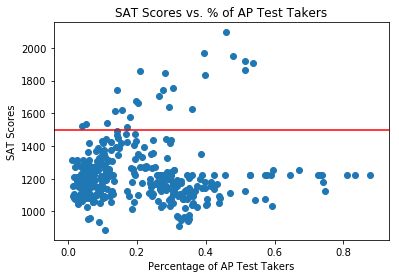

In [32]:
fig, ax = plt.subplots()
ax.scatter(x=ap_per, y=combined['sat_score'])
ax.set_xlabel("Percentage of AP Test Takers")
ax.set_ylabel("SAT Scores")
ax.axhline(y=1500, color='red')
plt.title('SAT Scores vs. % of AP Test Takers')
plt.show()